In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
atomistic_system = mda.Universe
from modules.RMSD import plot_RMSD
import warnings
%reload_ext autoreload
%autoreload 2
import input

In [2]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)

Aligned file found, reading this instead
Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement


In [3]:
#Options
#RMSD_groups = ["284 to 400" , "400 to 426" ]
#RMSD_groups_name = ["Core" , "C-term" ]
RMSD_groups = ["1 to 92"]
RMSD_groups_name = ["all"]
H_bonds = False
start_frame = 100
stop_frame = None
RMSD_groups_name.insert(0, "Overall")

In [4]:
grouplist =[]
for group in RMSD_groups:
    grouplist.append(f"protein and name CA and resid {group}")

# Calculate RMSD using the MDAnalysis functionality
ref_structure = reference_structure

# Input: simulation trajectory, reference structure, atoms to superimpose, atoms to calculate the RMSD for
RMSD = rms.RMSD(atomistic_system,      # Trajectory
                ref_structure,         # Reference structure
                select="protein and name CA",   #residus selection for superimposition     
                groupselections = grouplist)  # RMSD groups
# Run RMSD analysis
RMSD.run(verbose=True)

  0%|          | 0/25001 [00:00<?, ?it/s]

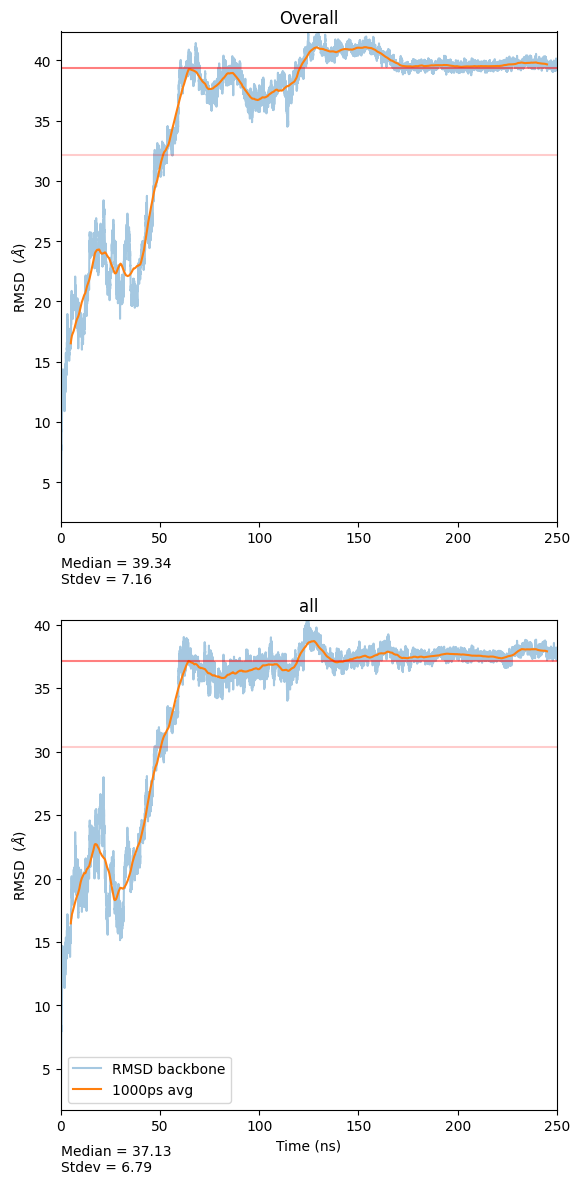

In [7]:
#Option to start the plot at specific time (cut of first ms of equilibration)
plot_0 = 0
# Extract data for plotting
rmsd = RMSD.results.rmsd.T  #T = transpose
# Extract the time data from the RMSD output. Divide by 1000 to get time in ns
time = rmsd[1]/1000

plot_RMSD(rmsd, time, RMSD_groups, RMSD_groups_name, plot_0)

Run RMSF calculation


  0%|          | 0/25001 [00:00<?, ?it/s]

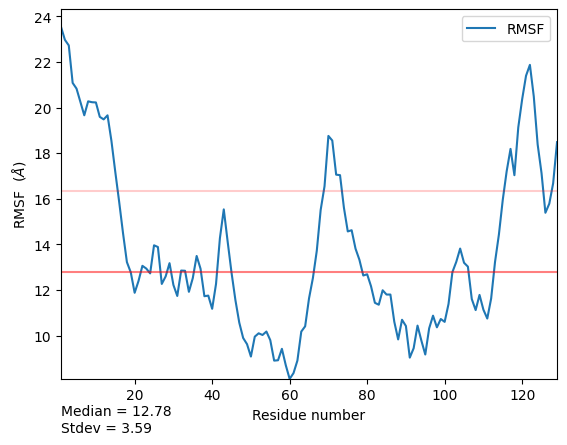

In [13]:
from modules.plot import plt_smooth, plt_median
import matplotlib.pyplot as plt 

if is_aligned:
    
    #Run RMSF analysis
    C_alphas = atomistic_system.select_atoms('protein and name CA')
    print("Run RMSF calculation")
    RMSF = rms.RMSF(C_alphas)
    RMSF.run(verbose=True)

    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(C_alphas.resids, RMSF.results.rmsf, label='RMSF')
    # Add axis labels
    ax.set_xlabel('Residue number')
    ax.set_ylabel('RMSF  ($\AA$)')

    # Set axis limits
    ax.set_xlim(C_alphas.resids[0], C_alphas.resids[-1] )
    ax.set_ylim(min(RMSF.results.rmsf))

    # plt median and + 1 stdev
    plt_median(ax, RMSF.results.rmsf, negative=False, label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

    # dynamically add new attributes
    # ('tempfactors' is pre-defined and filled with zeros as default values)
    atomistic_system.add_TopologyAttr('tempfactors')
    C_alphas.tempfactors = RMSF.results.rmsf


    #write PDB file with RMS as B factore
    if input.ligand_name:
        write_group = atomistic_system.select_atoms(f"(protein and name CA) or resname {input.ligand_name}")
    else:
        write_group = C_alphas

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        write_group.write(input.sim_path + input.sim_name +  "_RMSF.pdb")